<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/stock-price-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series forecasting: Apple stock prediction


In [174]:
!pip install yfinance --quiet

In [175]:
!pip install optuna

In [176]:
import yfinance as yf
import pandas as pd
import numpy as np
# getting data from Yahoo Finance
stock_name = 'AAPL'
data = yf.download(stock_name, start="2019-01-01", end="2025-04-01")

[*********************100%***********************]  1 of 1 completed


In [177]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2019-01-02,37.667191,37.889017,36.787049,36.944473,148158800
2019-01-03,33.915260,34.757238,33.869941,34.342211,365248800
2019-01-04,35.363068,35.432241,34.299268,34.473387,234428400
2019-01-07,35.284363,35.499034,34.800166,35.468025,219111200
2019-01-08,35.956993,36.212212,35.425093,35.673153,164101200


In [178]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-03-25,223.750000,224.100006,220.080002,220.770004,34493600
2025-03-26,221.529999,225.020004,220.470001,223.509995,34466100
2025-03-27,223.850006,224.990005,220.559998,221.389999,37094800
2025-03-28,217.899994,223.809998,217.679993,221.669998,39818600
2025-03-31,222.130005,225.619995,216.229996,217.009995,65299300


In [179]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1570 entries, 2019-01-02 to 2025-03-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1570 non-null   float64
 1   (High, AAPL)    1570 non-null   float64
 2   (Low, AAPL)     1570 non-null   float64
 3   (Open, AAPL)    1570 non-null   float64
 4   (Volume, AAPL)  1570 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 73.6 KB


In [180]:
data['close price']=data['Close']
data.index=pd.to_datetime(data.index)


In [181]:
data.drop(columns=['Open','High','Close','Low'],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1570 entries, 2019-01-02 to 2025-03-31
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Volume, AAPL)   1570 non-null   int64  
 1   (close price, )  1570 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 36.8 KB


In [182]:
data.head()

Price,Volume,close price
Ticker,AAPL,
Date,,
2019-01-02,148158800,37.667191
2019-01-03,365248800,33.915260
2019-01-04,234428400,35.363068
2019-01-07,219111200,35.284363
2019-01-08,164101200,35.956993


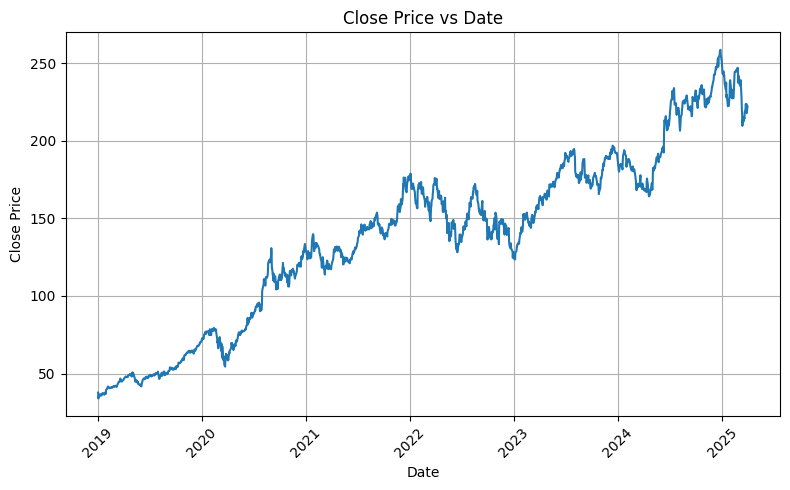

In [183]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(data.index, data['close price'])
plt.title('Close Price vs Date')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [184]:
from sklearn.metrics import mean_squared_error, r2_score

# Extract useful Date features
data['year'] = data.index.year
data['day'] = data.index.day
data['month'] = data.index.month
data['dayofweek'] = data.index.dayofweek

#These cyclic features help models understand periodic patterns like weekly or monthly seasonality.

# Day of month: 1 to 31
data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)

# Month: 1 to 12
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# Day of week: 0 (Monday) to 6 (Sunday)
data['dow_sin'] = np.sin(2 * np.pi * data['dayofweek'] / 7)
data['dow_cos'] = np.cos(2 * np.pi * data['dayofweek'] / 7)

# Define features and target
X = data[['day_sin','day_cos','month_sin','month_cos', 'dow_sin', 'dow_cos', 'year']]
y = data[['close price']]

In [185]:
# Number of past and future days for lag/lead
lags = [1, 3, 5, 7]
rolls = [2, 7, 14]

# LAG FEATURES (past prices and volumes)
for lag in lags:
    X[f'close_lag_{lag}'] = y['close price'].shift(lag)

# ROLLING MEAN FEATURES (trend indicators)
for r in rolls:
    X[f'close_roll_mean_{r}'] = y['close price'].rolling(window=r).mean()

X.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1570 entries, 2019-01-02 to 2025-03-31
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   (day_sin, )             1570 non-null   float64
 1   (day_cos, )             1570 non-null   float64
 2   (month_sin, )           1570 non-null   float64
 3   (month_cos, )           1570 non-null   float64
 4   (dow_sin, )             1570 non-null   float64
 5   (dow_cos, )             1570 non-null   float64
 6   (year, )                1570 non-null   int32  
 7   (close_lag_1, )         1569 non-null   float64
 8   (close_lag_3, )         1567 non-null   float64
 9   (close_lag_5, )         1565 non-null   float64
 10  (close_lag_7, )         1563 non-null   float64
 11  (close_roll_mean_2, )   1569 non-null   float64
 12  (close_roll_mean_7, )   1564 non-null   float64
 13  (close_roll_mean_14, )  1557 non-null   float64
dtypes: float64(13), int32(

<ipython-input-185-d33ca1a3a3ca>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'close_lag_{lag}'] = y['close price'].shift(lag)
<ipython-input-185-d33ca1a3a3ca>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'close_lag_{lag}'] = y['close price'].shift(lag)
<ipython-input-185-d33ca1a3a3ca>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [186]:
X.head(15)

Price,day_sin,day_cos,month_sin,month_cos,dow_sin,dow_cos,year,close_lag_1,close_lag_3,close_lag_5,close_lag_7,close_roll_mean_2,close_roll_mean_7,close_roll_mean_14
Ticker,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,
2019-01-02,0.394356,0.918958,0.5,0.866025,0.974928,-0.222521,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,0.571268,0.820763,0.5,0.866025,0.433884,-0.900969,2019,37.667191,NaN,NaN,NaN,35.791225,NaN,NaN
2019-01-04,0.724793,0.688967,0.5,0.866025,-0.433884,-0.900969,2019,33.915260,NaN,NaN,NaN,34.639164,NaN,NaN
2019-01-07,0.988468,0.151428,0.5,0.866025,0.000000,1.000000,2019,35.363068,37.667191,NaN,NaN,35.323715,NaN,NaN
2019-01-08,0.998717,-0.050649,0.5,0.866025,0.781831,0.623490,2019,35.284363,33.915260,NaN,NaN,35.620678,NaN,NaN
2019-01-09,0.968077,-0.250653,0.5,0.866025,0.974928,-0.222521,2019,35.956993,35.363068,37.667191,NaN,36.262299,NaN,NaN
2019-01-10,0.897805,-0.440394,0.5,0.866025,0.433884,-0.900969,2019,36.567604,35.284363,33.915260,NaN,36.626041,35.919851,NaN
2019-01-11,0.790776,-0.612106,0.5,0.866025,-0.433884,-0.900969,2019,36.684479,35.956993,35.363068,37.667191,36.504393,35.728010,NaN


In [187]:
# Drop rows with NaN values caused by shift/rolling
X = X.iloc[14:]
y = y.iloc[14:]

In [188]:
X.head(15)

Price,day_sin,day_cos,month_sin,month_cos,dow_sin,dow_cos,year,close_lag_1,close_lag_3,close_lag_5,close_lag_7,close_roll_mean_2,close_roll_mean_7,close_roll_mean_14
Ticker,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,
2019-01-23,-9.987165e-01,-0.050649,0.500000,0.866025,0.974928,-0.222521,2019,36.565220,37.175835,36.510353,36.324306,36.639162,36.729117,36.228564
2019-01-24,-9.884683e-01,0.151428,0.500000,0.866025,0.433884,-0.900969,2019,36.713104,37.404812,36.956390,35.778107,36.567600,36.821116,36.407624
2019-01-25,-9.377521e-01,0.347305,0.500000,0.866025,-0.433884,-0.900969,2019,36.422096,36.565220,37.175835,36.510353,37.025558,36.980925,36.569477
2019-01-28,-5.712682e-01,0.820763,0.500000,0.866025,0.000000,1.000000,2019,37.629021,36.713104,37.404812,36.956390,37.454903,37.027267,36.712079
2019-01-29,-3.943559e-01,0.918958,0.500000,0.866025,0.781831,0.623490,2019,37.280785,36.422096,36.565220,37.175835,37.087574,36.987057,36.779034
2019-01-30,-2.012985e-01,0.979530,0.500000,0.866025,0.974928,-0.222521,2019,36.894363,37.629021,36.713104,37.404812,38.154953,37.274305,36.982458
2019-01-31,-2.449294e-16,1.000000,0.500000,0.866025,0.433884,-0.900969,2019,39.415543,37.280785,36.422096,36.565220,39.557463,37.722042,37.197808
2019-02-01,2.012985e-01,0.979530,0.866025,0.500000,-0.433884,-0.900969,2019,39.699383,36.894363,37.629021,36.713104,39.708921,38.151379,37.440248


In [189]:
y

Price,close price
Ticker,
Date,
2019-01-23,36.713104
2019-01-24,36.422096
2019-01-25,37.629021
2019-01-28,37.280785
2019-01-29,36.894363
...,...
2025-03-25,223.750000
2025-03-26,221.529999


In [190]:
from sklearn.model_selection import train_test_split
# Train-test split without shuffle for time-series
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)
print("Testing Dates:", len(X_test))
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, shuffle=False)
print("Training Dates:", len(X_train))
print("val Dates:", len(X_val))
X_train.head()

Testing Dates: 78
Training Dates: 1256
val Dates: 222


Price,day_sin,day_cos,month_sin,month_cos,dow_sin,dow_cos,year,close_lag_1,close_lag_3,close_lag_5,close_lag_7,close_roll_mean_2,close_roll_mean_7,close_roll_mean_14
Ticker,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,
2019-01-23,-0.998717,-0.050649,0.5,0.866025,0.974928,-0.222521,2019,36.565220,37.175835,36.510353,36.324306,36.639162,36.729117,36.228564
2019-01-24,-0.988468,0.151428,0.5,0.866025,0.433884,-0.900969,2019,36.713104,37.404812,36.956390,35.778107,36.567600,36.821116,36.407624
2019-01-25,-0.937752,0.347305,0.5,0.866025,-0.433884,-0.900969,2019,36.422096,36.565220,37.175835,36.510353,37.025558,36.980925,36.569477
2019-01-28,-0.571268,0.820763,0.5,0.866025,0.000000,1.000000,2019,37.629021,36.713104,37.404812,36.956390,37.454903,37.027267,36.712079
2019-01-29,-0.394356,0.918958,0.5,0.866025,0.781831,0.623490,2019,37.280785,36.422096,36.565220,37.175835,37.087574,36.987057,36.779034


# facebook Prophet model

In [191]:
#!pip install prophet

In [192]:
from prophet import Prophet

from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

prophet_data_train=y_train
prophet_data_train['ds']=y_train.index
prophet_data_train=prophet_data_train.rename(columns={'close price':'y'})

prophet_data_val=y_val
prophet_data_val['ds']=y_val.index
prophet_data_val=prophet_data_val.rename(columns={'close price':'y'})

prophet_data_test=y_test
prophet_data_test['ds']=y_test.index
prophet_data_test=prophet_data_test.rename(columns={'close price':'y'})

prophet_data_train.head()

Price,y,ds
Ticker,,
Date,,
2019-01-23,36.713104,2019-01-23
2019-01-24,36.422096,2019-01-24
2019-01-25,37.629021,2019-01-25
2019-01-28,37.280785,2019-01-28
2019-01-29,36.894363,2019-01-29


DEBUG:cmdstanpy:input tempfile: /tmp/tmplapfttkr/nk5cjmpk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplapfttkr/h6jz5af0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87564', 'data', 'file=/tmp/tmplapfttkr/nk5cjmpk.json', 'init=/tmp/tmplapfttkr/h6jz5af0.json', 'output', 'file=/tmp/tmplapfttkr/prophet_modelxhy94ngy/prophet_model-20250430230501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:05:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


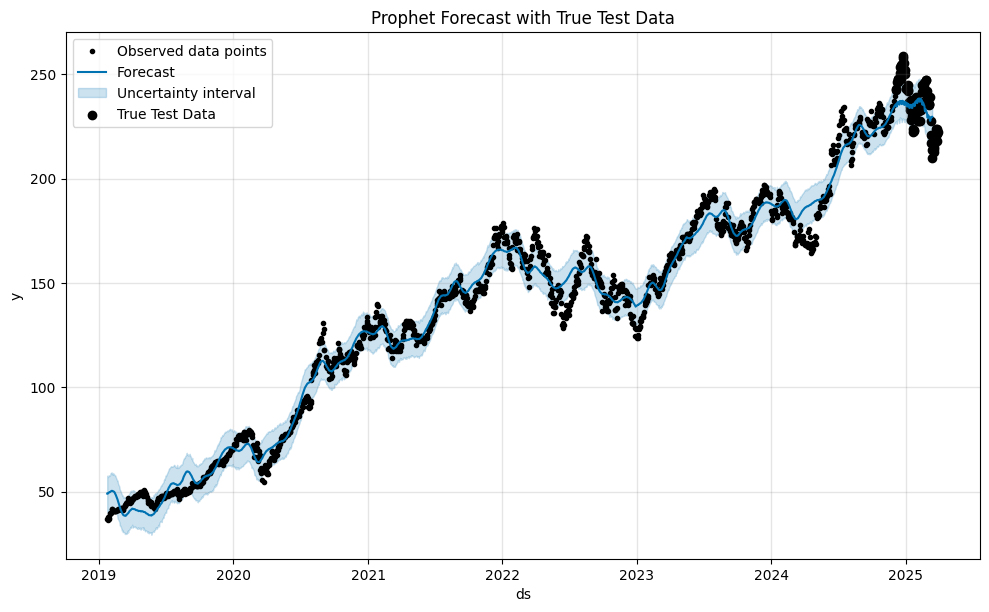

RMSE on test data: 10.820185208872967


In [193]:
# 2. Combine train and validation data for fitting
train_val_data = pd.concat([prophet_data_train, prophet_data_val])

# 3. Initialize and fit Prophet on train+val data
model = Prophet(daily_seasonality=True)
model.fit(train_val_data)

# 4. Create future dataframe for the test data's dates
future = model.make_future_dataframe(periods=100)  # No extra days to predict, just for test dates

# 5. Forecast
forecast = model.predict(future)

# 6. Plot the forecast
fig = model.plot(forecast)

# Overlay the true test data values
plt.scatter(prophet_data_test['ds'], prophet_data_test['y'], color='black', label='True Test Data')
plt.title('Prophet Forecast with True Test Data')
plt.legend()
plt.show()

# 7. Optionally, evaluate the performance on test data
from sklearn.metrics import mean_squared_error
y_true = prophet_data_test['y']
y_pred = forecast['yhat'][-len(prophet_data_test):]

# Calculate RMSE (Root Mean Squared Error) as an example
rmse = root_mean_squared_error(y_true, y_pred)
print(f'RMSE on test data: {rmse}')


## fine-tuning hyperparameters of Prophet model with optuna

[I 2025-04-30 23:05:05,091] A new study created in memory with name: no-name-dcbdfec2-b11f-47e0-989d-2c9190775e37
DEBUG:cmdstanpy:input tempfile: /tmp/tmplapfttkr/hchk_w6c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplapfttkr/_99dm6yc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26653', 'data', 'file=/tmp/tmplapfttkr/hchk_w6c.json', 'init=/tmp/tmplapfttkr/_99dm6yc.json', 'output', 'file=/tmp/tmplapfttkr/prophet_model9t8i4rkn/prophet_model-20250430230505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:05:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
[I 2025-04-30 23:05:08,091] Trial 0 finished with value: 27.73159178787277 and parameters: {'seasonality_prior_scale': 0.9893634

Best hyperparameters: {'seasonality_prior_scale': 8.242266921306543, 'changepoint_prior_scale': 0.010173890583233411, 'holidays_prior_scale': 3.617665327580494}


DEBUG:cmdstanpy:input tempfile: /tmp/tmplapfttkr/tltl0fwv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62298', 'data', 'file=/tmp/tmplapfttkr/sj1pehar.json', 'init=/tmp/tmplapfttkr/tltl0fwv.json', 'output', 'file=/tmp/tmplapfttkr/prophet_modeloxfv16rv/prophet_model-20250430230546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:05:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


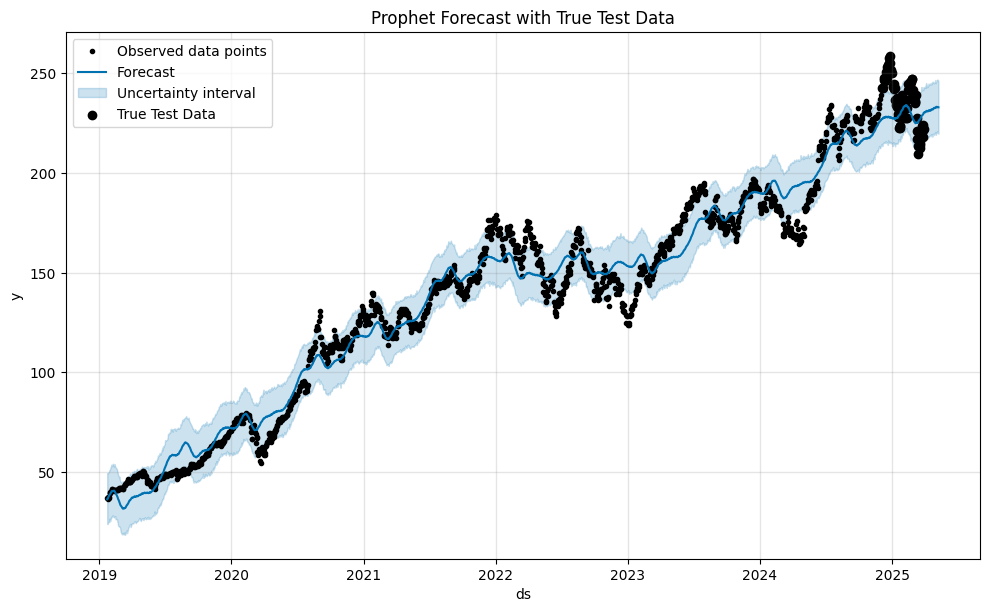

RMSE on test data: 15.417638646856574


In [194]:
from sklearn.metrics import mean_absolute_error

# Define the objective function for optimization
def objective(trial):
    # Hyperparameter suggestions
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.1, 10.0)
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.01, 0.1)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.1, 10.0)

    # Create and fit the model
    model = Prophet(
        seasonality_prior_scale=seasonality_prior_scale,
        changepoint_prior_scale=changepoint_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        daily_seasonality=True
    )

    # Prepare the training and validation data
    train_val_data = pd.concat([prophet_data_train, prophet_data_val])
    model.fit(train_val_data)

    # Make future predictions (on the validation data period)
    future = model.make_future_dataframe(periods=100)
    forecast = model.predict(future)

    # Extract the predicted values for the validation period
    val_forecast = forecast['yhat'][-len(prophet_data_val):]
    val_true = prophet_data_val['y']

    # Evaluate RMSE (or you can use MAE or other metrics)
    rmse = root_mean_squared_error(val_true, val_forecast)
    return rmse

# Create the study
study = optuna.create_study(direction='minimize')

# Perform optimization over a number of trials
study.optimize(objective, n_trials=25)

# Get the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Use the best hyperparameters to fit the final model
best_params = study.best_params
final_model = Prophet(
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    daily_seasonality=True
)

# Combine train and validation data for final fitting
train_val_data = pd.concat([prophet_data_train, prophet_data_val])
final_model.fit(train_val_data)

# Make future dataframe for test data's dates
future = final_model.make_future_dataframe(periods=156)

# Forecast
forecast = final_model.predict(future)

# Plot the forecast
fig = final_model.plot(forecast)

# Overlay the true test data values
plt.scatter(prophet_data_test['ds'], prophet_data_test['y'], color='black', label='True Test Data')
plt.title('Prophet Forecast with True Test Data')
plt.legend()
plt.show()

# Evaluate the performance on test data
y_true = prophet_data_test['y']
y_pred = forecast['yhat'][-len(prophet_data_test):]

# Calculate RMSE (Root Mean Squared Error) as an example
rmse = root_mean_squared_error(y_true, y_pred)
print(f'RMSE on test data: {rmse}')


# XGBRegression with fine-tuning with optuna

In [195]:
from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit on training features only (to avoid data leakage)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train

array([[0.00000000e+00, 4.73324314e-01, 7.50000000e-01, ...,
        4.46464600e-04, 0.00000000e+00, 0.00000000e+00],
       [5.13067661e-03, 5.74622652e-01, 7.50000000e-01, ...,
        0.00000000e+00, 5.79808203e-04, 1.13424535e-03],
       [3.05213615e-02, 6.72813282e-01, 7.50000000e-01, ...,
        2.85714021e-03, 1.58698703e-03, 2.15950060e-03],
       ...,
       [4.49350831e-01, 0.00000000e+00, 7.50000000e-01, ...,
        9.17766264e-01, 9.25896845e-01, 9.47679323e-01],
       [3.50126076e-01, 2.04174111e-02, 7.50000000e-01, ...,
        9.07719591e-01, 9.27239288e-01, 9.43015294e-01],
       [2.57037178e-01, 6.04163420e-02, 7.50000000e-01, ...,
        9.23223654e-01, 9.29986832e-01, 9.40982375e-01]])

In [199]:
y_train.drop(columns=['ds'],inplace=True)
y_val.drop(columns=['ds'],inplace=True)
y_test.drop(columns=['ds'],inplace=True)

In [200]:
import xgboost
print(xgboost.__version__)


2.1.4


In [201]:
import optuna
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error

# Create study
study = optuna.create_study(direction="minimize")

# Loop over trials
for _ in range(20):
    # Ask for a new trial
    trial = study.ask()

    # Suggest hyperparameters using trial object
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 20, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),   # L1
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10), # L2
        'eval_metric': 'rmse',
        'random_state': 42
    }

    # Train and evaluate model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        evals=[(dval, 'eval')],
        early_stopping_rounds=20,
        evals_result=evals_result,
        verbose_eval=False
    )

    preds = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val, preds))

    study.tell(trial, rmse)

print("Best RMSE:", study.best_value)
print("Best Parameters:", study.best_params)



[I 2025-04-30 23:08:03,252] A new study created in memory with name: no-name-f954d94d-a4ed-4a43-a8c3-b51df1e3efd4
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:08:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:08:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:08:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:08:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:15

Best RMSE: 49.45140942916845
Best Parameters: {'n_estimators': 276, 'learning_rate': 0.09535285776108553, 'max_depth': 3, 'gamma': 0.3844763492827921, 'min_child_weight': 49, 'reg_alpha': 9.82446360899603, 'reg_lambda': 5.022270597884397}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:08:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [202]:
best_params = study.best_params
best_params['random_state'] = 42
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)  # or X_train, y_train if you want

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3844763492827921, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09535285776108553,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=49, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=276, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [203]:
from xgboost import plot_importance

importances = final_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame(importances.items(), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print(importance_df)


   Feature    Importance
8       f8  69026.781250
11     f11  36448.539062
10     f10   2551.299805
9       f9   1712.859985
12     f12    954.026855
7       f7    773.760376
13     f13    229.696838
6       f6     10.022411
3       f3      3.684800
0       f0      3.578391
5       f5      3.494805
2       f2      3.046806
1       f1      2.772085
4       f4      2.069204


In [204]:
# Example: Predict on same training data (for demo)
y_pred = final_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print("Final RMSE on training set:", rmse)

Final RMSE on training set: 46.05482482910156


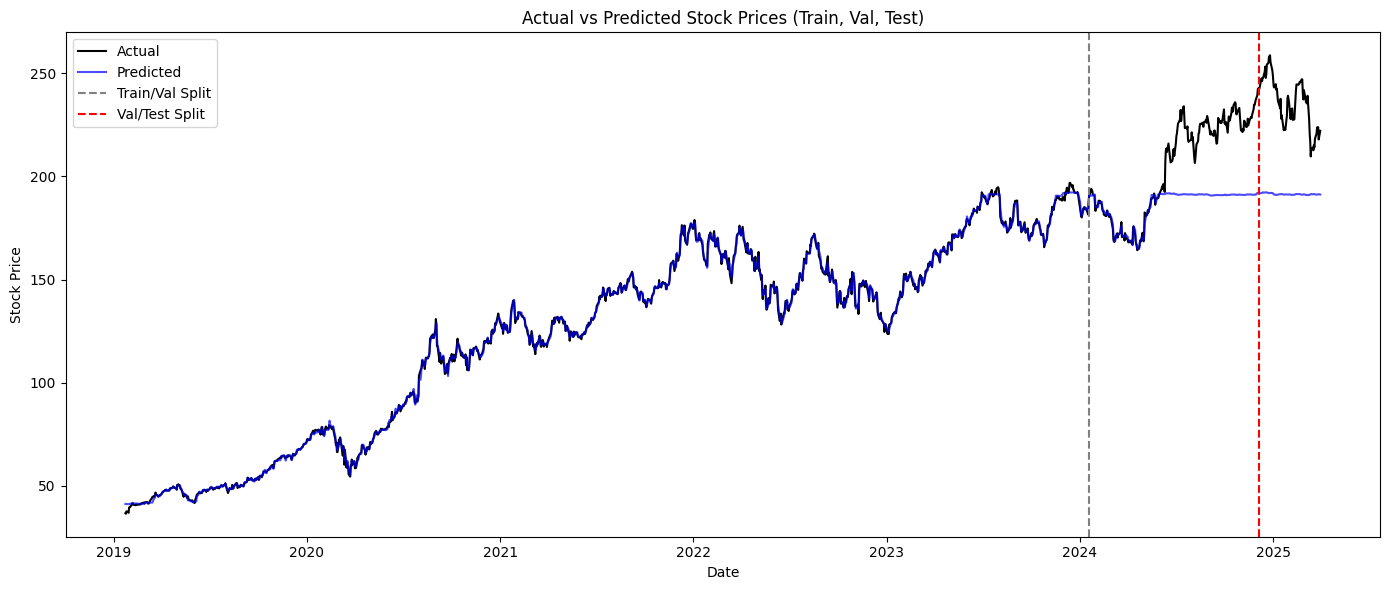

In [205]:
# 3. Make predictions
train_pred = final_model.predict(X_train)
val_pred = final_model.predict(X_val)
test_pred = final_model.predict(X_test)

train_size = int(len(X_train))
val_size = int(len(X_val))
test_size = int(len(X_test))

# 4. Create a DataFrame for plotting
pred_df = pd.DataFrame({
    'date': X.index,  # original DataFrame index was datetime
    'actual': y.values.ravel(),
    'set': ['train'] * len(y_train) + ['val'] * len(y_val) + ['test'] * len(y_test),
    'predicted': list(train_pred) + list(val_pred) + list(test_pred)
})

# 5. Plot
plt.figure(figsize=(14, 6))
plt.plot(pred_df['date'], pred_df['actual'], label='Actual', color='black')
plt.plot(pred_df['date'], pred_df['predicted'], label='Predicted', color='blue', alpha=0.7)
plt.axvline(pred_df['date'].iloc[train_size], color='gray', linestyle='--', label='Train/Val Split')
plt.axvline(pred_df['date'].iloc[train_size + val_size], color='red', linestyle='--', label='Val/Test Split')
plt.title("Actual vs Predicted Stock Prices (Train, Val, Test)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.tight_layout()
plt.show()

# SARIMAX:

In [208]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMAX model with lag features as exogenous variables
model = SARIMAX(y_train,
                exog=X_train,  # Pass the lag features here as exogenous variables
                order=(1, 1, 0),  # Non-seasonal AR(1) process (p=1)
                seasonal_order=(1, 1, 0, 5),  # Seasonal AR(1) process (P=1) and seasonality length S=5 (example)
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
sarimax_result = model.fit(disp=False)



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


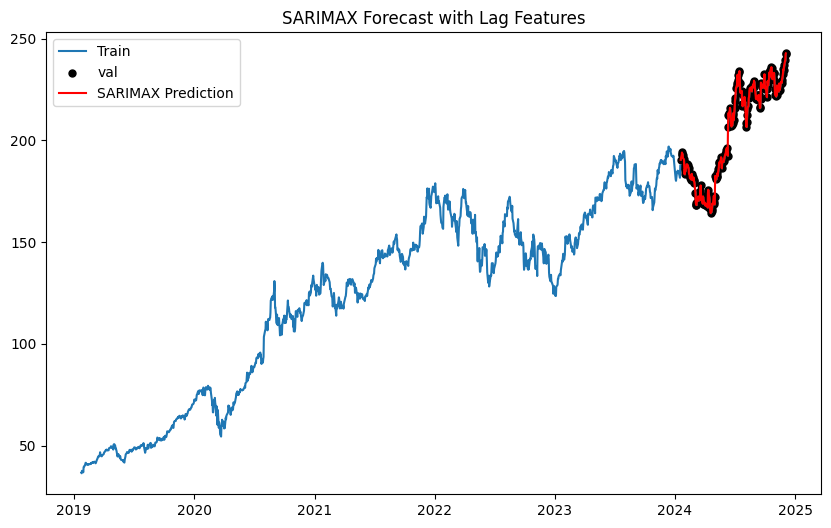

In [221]:
# Forecast for the test data
forecast = sarimax_result.get_forecast(steps=len(X_val), exog=X_val)

# Predicted values
predicted_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train['close price'], label='Train')
plt.scatter(y_val.index, y_val['close price'], label='val', color='black', s=25)
plt.plot(y_val.index, predicted_mean, label='SARIMAX Prediction', color='red')
plt.fill_between(y_val.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('SARIMAX Forecast with Lag Features')
plt.show()

In [213]:
X_train_val = np.vstack([X_train, X_val])  # Combine the exogenous variables for training and validation

In [214]:
train_val_data=pd.concat([y_train, y_val])

In [215]:
model_final = SARIMAX(train_val_data['close price'].values,
                     exog=X_train_val,  # Combined exogenous variables (as numpy array)
                     order=(1, 1, 0),  # Same orders used earlier
                     seasonal_order=(1, 1, 0, 5),  # Same seasonal orders
                     enforce_stationarity=False,
                     enforce_invertibility=False)

# Fit the final model on train + val data
sarimax_result_final = model_final.fit(disp=False)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [216]:
# Forecast for the test data
forecast = sarimax_result_final.get_forecast(steps=len(X_test), exog=X_test)

# Predicted values
predicted_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()


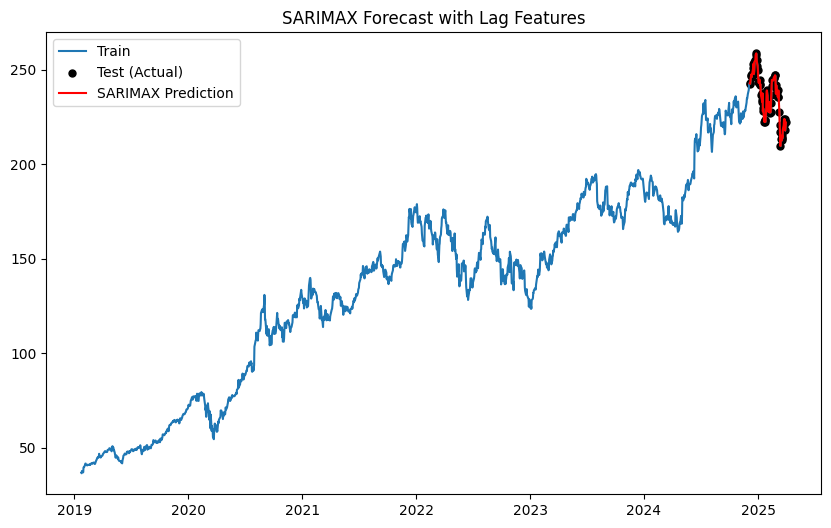

In [220]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_val_data.index, train_val_data['close price'], label='Train')
plt.scatter(y_test.index, y_test['close price'], label='Test (Actual)', color='black', s=25)
plt.plot(y_test.index, predicted_mean, label='SARIMAX Prediction', color='red')
plt.fill_between(
    y_test.index,
    confidence_intervals[:, 0],  # Lower bound
    confidence_intervals[:, 1],  # Upper bound
    color='pink',
    alpha=0.3
)

plt.legend()
plt.title('SARIMAX Forecast with Lag Features')
plt.show()